In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
def simulate_xt(x0, t):
    t = t.view(-1, 1)
    m_t = torch.exp(-t)
    sigma_t = torch.sqrt(1 - torch.exp(-2 * t))
    z = torch.randn_like(x0)
    xt = m_t * x0 + sigma_t * z
    return xt, z, m_t, sigma_t

In [3]:
N_SAMPLES = 100_000

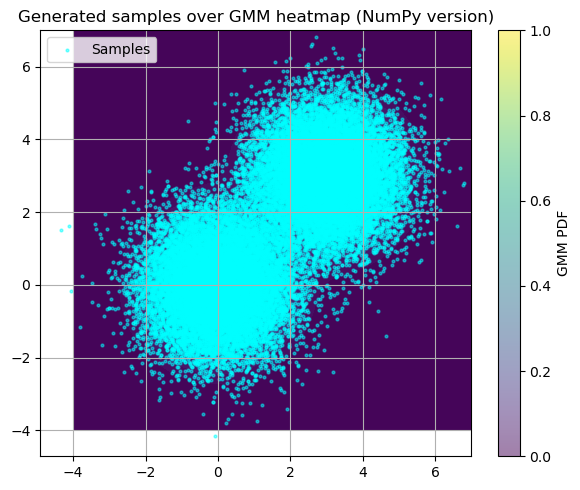

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def simple_gmm_sample(N, pi=0.5, mu1=[0, 0], mu2=[3, 3], sigma1=1.0, sigma2=1.0, device='cpu'):
    mu1 = torch.tensor(mu1, device=device)
    mu2 = torch.tensor(mu2, device=device)

    mix_indicator = torch.rand(N, device=device) < pi
    eps = torch.randn(N, 2, device=device)

    samples = torch.where(
        mix_indicator.unsqueeze(1),
        mu1 + sigma1 * eps,
        mu2 + sigma2 * eps
    )
    return samples

samples = simple_gmm_sample(30000)

x, y = np.mgrid[-4:7:80j, -4:7:80j]
pos = np.dstack((x, y))
rv1 = multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]])
rv2 = multivariate_normal(mean=[3, 3], cov=[[1, 0], [0, 1]])
pdf = 0.5 * rv1.pdf(pos) + 0.5 * rv2.pdf(pos)

plt.figure(figsize=(6, 5))
plt.contourf(x, y, pdf, levels=40, cmap='viridis')
plt.scatter(samples[:, 0], samples[:, 1], s=4, alpha=0.5, color='cyan', label='Samples')
plt.colorbar(label='GMM PDF')
plt.title('Generated samples over GMM heatmap (NumPy version)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
def generate_gmm_data(sample_fn, n_samples, T=3.0, device='cpu'):
    x0 = sample_fn(n_samples).to(device)
    t = torch.rand(n_samples, 1, device=device) * T
    m_t = torch.exp(-t)
    z = torch.randn(n_samples, 2, device=device)
    xt = m_t * x0 + torch.sqrt(1 - m_t**2) * z
    return x0, t, z, xt

In [6]:
device = "cpu"

In [7]:
class ScoreNet(nn.Module):
    def __init__(self, d=2, N=128, activation='relu'):
        super().__init__()
        self.N = N
        self.d = d
        self.input_dim = d + 1

        self.w = nn.Parameter(torch.randn(N, self.input_dim))
        self.b = nn.Parameter(torch.randn(N))
        self.a = nn.Parameter(torch.randn(N, d))

        if activation == 'relu':
            self.activation = torch.relu
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        else:
            raise ValueError("Unknown activation")

    def forward(self, t, x):
        if t.dim() == 1:
            t = t.unsqueeze(1)
        x_input = torch.cat([x, t], dim=1)

        B = x_input.shape[0]

        x_exp = x_input.unsqueeze(1)
        w_exp = self.w.unsqueeze(0)
        b_exp = self.b.unsqueeze(0).unsqueeze(-1)
        a_exp = self.a.unsqueeze(0)

        inner = torch.sum(w_exp * x_exp, dim=-1, keepdim=True)
        h = self.activation(inner + b_exp)
        contrib = h * a_exp

        return contrib.mean(dim=1)

In [8]:
import torch.nn as nn

class ScoreNet(nn.Module):
    def __init__(self, d=2, hidden_dim=128):
        super().__init__()
        input_dim = d + 1

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, d)
        )


    def forward(self, t, x):
        if t.dim() == 1:
            t = t.unsqueeze(1)
        x_in = torch.cat([x, t], dim=1)
        return self.net(x_in)


In [9]:
def compute_H(net, x0, t, z):
    B, d = x0.shape
    m_t = torch.exp(-t)
    sigma_t = torch.sqrt(1 - torch.exp(-2 * t))
    kappa_t = sigma_t ** 2
    x_t = m_t * x0 + sigma_t * z
    x_t.requires_grad_(True)
    s = net(t, x_t)
    total_grad = [torch.zeros_like(p) for p in net.parameters()]

    for i in range(B):
        x_i = x_t[i].view(1, -1).clone().detach().requires_grad_(True)
        t_i = t[i].view(1, 1)
        z_i = z[i]

        s_i = net(t_i, x_i)[0]

        sigma_inv_z = z_i / sigma_t[i]
        coeff = sigma_inv_z + s_i

        for j in range(d):
            grad_sij = torch.autograd.grad(
                outputs=s_i[j],
                inputs=list(net.parameters()),
                retain_graph=True,
                create_graph=True,
                allow_unused=True
            )
            for k in range(len(total_grad)):
                if grad_sij[k] is not None:
                    total_grad[k] += 2 * kappa_t[i, 0] * coeff[j] * grad_sij[k]

    return total_grad

In [10]:
def sgld_update(params, grads, lr, beta):
    updated = []
    for p, g in zip(params, grads):
        noise = torch.randn_like(p)
        noise_scale = (2 * lr / beta) ** 0.5
        p_new = p - lr * g + noise_scale * noise
        updated.append(p_new)
    return updated

In [11]:
net = ScoreNet()
net.train()

ScoreNet(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [12]:
from functools import partial

sample_fn = partial(simple_gmm_sample, 
                    pi=0.5,
                    mu1=[0, 0],
                    mu2=[3, 3],
                    sigma1=1.0,
                    sigma2=1.0,
                    device=device)

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = ScoreNet(d=2).to(device)
B, d = 64, 2
lr = 1e-3
beta = 10**8
num_steps = 30000
grad_norms = []
theta_trajectory = []

In [14]:
best_H = float('inf')
theta_hat_best = None

for step in range(num_steps):
    x0, t, z, xt = generate_gmm_data(sample_fn, n_samples=B, device=device)
    grads = compute_H(net, x0, t, z)
    grad_norm = torch.sqrt(sum(g.norm()**2 for g in grads if g is not None))
    grad_norms.append(grad_norm.item())
    updated_params = sgld_update(list(net.parameters()), grads, lr, beta)

    with torch.no_grad():
        for p, new_p in zip(net.parameters(), updated_params):
            p.copy_(new_p)

        H_value = sum((g**2).sum().item() for g in grads if g is not None)

        if H_value < best_H:
            best_H = H_value
            theta_hat_best = {
                name: p.detach().clone().cpu()
                for name, p in net.named_parameters()
            }

        theta = torch.cat([p.flatten() for p in net.parameters()])
        theta_trajectory.append(theta.cpu().numpy())

In [15]:
for name, p in net.named_parameters():
    print(name, torch.norm(p).item())

net.0.weight 6.382607936859131
net.0.bias 4.067038059234619
net.2.weight 7.377720355987549
net.2.bias 0.8836044669151306
net.4.weight 6.934657573699951
net.4.bias 0.9424868226051331
net.6.weight 1.7470556497573853
net.6.bias 0.03693777322769165


In [16]:
with torch.no_grad():
    for name, p in net.named_parameters():
        p.copy_(theta_hat_best[name].to(p.device))

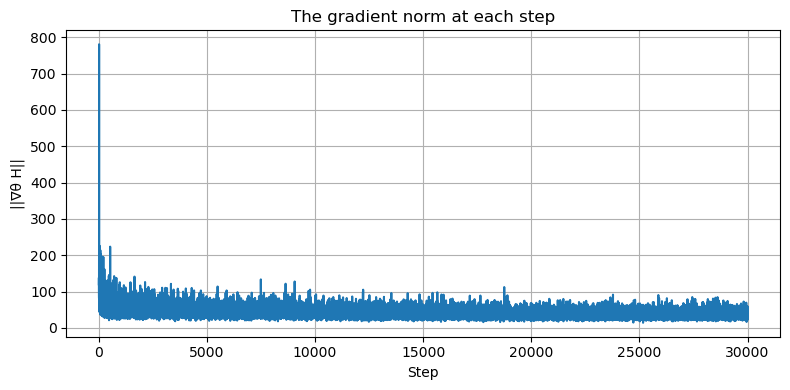

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(grad_norms)
plt.title("The gradient norm at each step")
plt.xlabel("Step")
plt.ylabel("||∇θ H||")
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

N_samples = 30000
dim = 2
K = 100000
T = 6.0
gamma = T/K
timesteps = np.linspace(0, T, K + 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
x0 = sample_fn(N_samples).to(device)
t_T = torch.full((N_samples, 1), T, device=device)
m_T = torch.exp(-t_T)
sigma_T = torch.sqrt(1 - torch.exp(-2 * t_T))
z = torch.randn_like(x0)
x_T = m_T * x0 + sigma_T * z
Y = x_T.clone()
for k in tqdm(range(K)):
    t_k = timesteps[k]
    tau = torch.full((N_samples, 1), T - t_k, device=device)

    with torch.no_grad():
        s_val = net(tau, Y)

    drift = Y + 2 * s_val
    noise = torch.randn_like(Y)
    Y = Y + gamma * drift + torch.sqrt(torch.tensor(2 * gamma)) * noise

samples = Y.cpu().numpy()

100%|██████████████████████████████████| 100000/100000 [10:19<00:00, 161.34it/s]


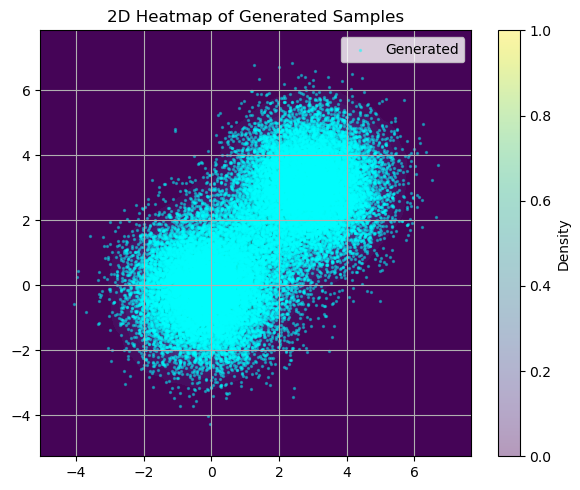

In [19]:
from scipy.stats import gaussian_kde

xy = samples.T
kde = gaussian_kde(xy)

x = np.linspace(np.min(samples[:, 0]) - 1, np.max(samples[:, 0]) + 1, 200)
y = np.linspace(np.min(samples[:, 1]) - 1, np.max(samples[:, 1]) + 1, 200)
X, Y_grid = np.meshgrid(x, y)
positions = np.vstack([X.ravel(), Y_grid.ravel()])
Z = kde(positions).reshape(X.shape)

plt.figure(figsize=(6, 5))
plt.contourf(X, Y_grid, Z, levels=50, cmap='viridis')
plt.scatter(samples[:, 0], samples[:, 1], s=2, alpha=0.4, color='cyan', label='Generated')
plt.colorbar(label="Density")
plt.title("2D Heatmap of Generated Samples")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
@torch.no_grad()
def sliced_w2(x: torch.Tensor, y: torch.Tensor, L: int = 256):

    assert x.dim()==2 and y.dim()==2 and x.size(1)==y.size(1)
    d = x.size(1)
    n = min(x.size(0), y.size(0))

    idx_x = torch.randperm(x.size(0), device=x.device)[:n]
    idx_y = torch.randperm(y.size(0), device=y.device)[:n]
    X = x[idx_x]
    Y = y[idx_y]

    U = torch.randn(L, d, device=X.device)
    U = U / (U.norm(dim=1, keepdim=True) + 1e-12)

    Xp = X @ U.t()
    Yp = Y @ U.t()
    Xp_sorted, _ = torch.sort(Xp, dim=0)
    Yp_sorted, _ = torch.sort(Yp, dim=0)

    w2_sq_all = torch.mean((Xp_sorted - Yp_sorted)**2, dim=0)  # [L]
    return torch.sqrt(torch.mean(w2_sq_all) + 1e-12)


def _hungarian(cost: torch.Tensor):
    try:
        from scipy.optimize import linear_sum_assignment
    except Exception as e:
        raise RuntimeError("Need scipy: pip install scipy") from e
    row_ind, col_ind = linear_sum_assignment(cost.detach().cpu().numpy())
    return torch.tensor(row_ind), torch.tensor(col_ind)


@torch.no_grad()
def w2_2d_exact_hungarian(x: torch.Tensor, y: torch.Tensor, max_points: int = 3000):

    assert x.dim()==2 and y.dim()==2 and x.size(1)==y.size(1)
    n = min(x.size(0), y.size(0), max_points)

    idx_x = torch.randperm(x.size(0), device=x.device)[:n]
    idx_y = torch.randperm(y.size(0), device=y.device)[:n]
    X = x[idx_x]
    Y = y[idx_y]

    X2 = (X**2).sum(dim=1, keepdim=True)
    Y2 = (Y**2).sum(dim=1, keepdim=True).t()
    C = torch.clamp(X2 + Y2 - 2*(X @ Y.t()), min=0.0)

    r, c = _hungarian(C)
    cost = C[r, c].mean()
    return torch.sqrt(cost + 1e-12), n


In [21]:
true = sample_fn(N_samples).to(device)
gen  = torch.from_numpy(samples).to(device)

sw2 = sliced_w2(true, gen, L=256)
print(f"Sliced W2 (2D): {float(sw2):.4f}")

w2_exact, n_used = w2_2d_exact_hungarian(true, gen, max_points=3000)
print(f"Exact W2 (Hungarian, n={n_used}): {float(w2_exact):.4f}")

Sliced W2 (2D): 0.1647
Exact W2 (Hungarian, n=3000): 0.2559
